<a href="https://colab.research.google.com/github/CodeBy-Omar/credit-home-risk-ML/blob/main/home_credit_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
pip install lightgbm xgboost catboost


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler






# Start by reading files form the drive.

In [19]:
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/aman task/home-credit-default-risk'
df_train = pd.read_csv(f'{folder}/application_train.csv')
df_test  = pd.read_csv(f'{folder}/application_test.csv')

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape: (307511, 122)
Test shape: (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


insights:
- The proportion of the test set to the train set is good enough.
- The number of columns is the same, with the train set having one additional column (the target), which is expected.

Important Notes:
- 0 indicates the loan was repaid, while 1 means the loan was not repaid ---> this is very important, as the choice of evaluation metric will depend on this.
- This analysis currently uses only the application CSV file. Other files can be added later to enhance the model.

# EDA & Feature Engineering

save this as csv file to be bale to see all columns.

In [20]:
# Total rows in the dataset
total_rows = len(df_train)

# Get % missing per column and filter > 0
missing_percent = (df_train.isna().sum() / total_rows) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

# Save to CSV
missing_percent.to_csv('missing_values_summary.csv')




In [21]:
missing_percent.head(60)

,0
COMMONAREA_MEDI,69.872297
COMMONAREA_MODE,69.872297
COMMONAREA_AVG,69.872297
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963
NONLIVINGAPARTMENTS_AVG,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MEDI,68.354953
LIVINGAPARTMENTS_MODE,68.354953


many columns have more than 50% of null values , it is very hard to impute or fill or even do new category because we are just introducing noise. hence they are worth removing except the EXT_SOURCE columns/ These are external risk scores from third-party credit agencies or proprietary scoring models used by Home Credit.
however before removing any , lets investigate the REQ_CREDIT_BUREAU columns.

In [22]:
bureau_cols = [
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]
for col in bureau_cols:
    print(f"\n{col} value counts:")
    print(df_train[col].value_counts(dropna=False).sort_index())



AMT_REQ_CREDIT_BUREAU_HOUR value counts:
AMT_REQ_CREDIT_BUREAU_HOUR
0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
NaN     41519
Name: count, dtype: int64

AMT_REQ_CREDIT_BUREAU_DAY value counts:
AMT_REQ_CREDIT_BUREAU_DAY
0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
8.0         1
9.0         2
NaN     41519
Name: count, dtype: int64

AMT_REQ_CREDIT_BUREAU_WEEK value counts:
AMT_REQ_CREDIT_BUREAU_WEEK
0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
5.0        10
6.0        20
7.0         2
8.0         5
NaN     41519
Name: count, dtype: int64

AMT_REQ_CREDIT_BUREAU_MON value counts:
AMT_REQ_CREDIT_BUREAU_MON
0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
8.0        185
9.0        206
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
1

These features all have a large number of zero values, and since this data is typically extracted from external credit sources, it is reasonable to assume that missing values indicate no inquiries were made. Additionally, all six columns share exactly the same missing rows, which further supports the idea that these clients likely had no prior inquiries recorded. Therefore, imputing the missing values with 0 is a safe and justifiable approach.

In [23]:

df_train[bureau_cols] = df_train[bureau_cols].fillna(0)
df_test[bureau_cols] = df_test[bureau_cols].fillna(0)


Another noticeable pattern in the missing columns CSV file is that most of the columns with high missing values (over 50–60%) have suffixes like _AVG, _MODE, or _MEDI, such as COMMONAREA_MODE and NONLIVINGAPARTMENTS_AVG. These features are primarily normalized building-related indicators, and due to the extremely high proportion of missing values, imputing them would not be meaningful or reliable. Therefore, they can be safely dropped from the dataset to reduce noise and simplify preprocessing.the picture clearly shows all columns we excluded in only this step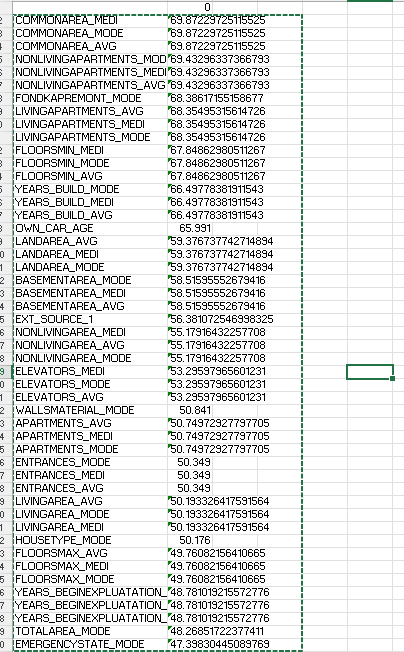

In [24]:
columns_to_drop = [
    "COMMONAREA_MEDI", "COMMONAREA_MODE", "COMMONAREA_AVG",
    "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAPARTMENTS_AVG",
    "FONDKAPREMONT_MODE",
    "LIVINGAPARTMENTS_AVG", "LIVINGAPARTMENTS_MEDI", "LIVINGAPARTMENTS_MODE",
    "FLOORSMIN_MEDI", "FLOORSMIN_MODE", "FLOORSMIN_AVG",
    "YEARS_BUILD_MODE", "YEARS_BUILD_MEDI", "YEARS_BUILD_AVG",
    "LANDAREA_AVG", "LANDAREA_MEDI", "LANDAREA_MODE",
    "BASEMENTAREA_MODE", "BASEMENTAREA_MEDI", "BASEMENTAREA_AVG",
    "NONLIVINGAREA_MEDI", "NONLIVINGAREA_AVG", "NONLIVINGAREA_MODE",
    "ELEVATORS_MEDI", "ELEVATORS_MODE", "ELEVATORS_AVG",
    "WALLSMATERIAL_MODE",
    "APARTMENTS_AVG", "APARTMENTS_MEDI", "APARTMENTS_MODE",
    "ENTRANCES_MODE", "ENTRANCES_MEDI", "ENTRANCES_AVG",
    "LIVINGAREA_AVG", "LIVINGAREA_MODE", "LIVINGAREA_MEDI",
    "HOUSETYPE_MODE",
    "FLOORSMAX_AVG", "FLOORSMAX_MEDI", "FLOORSMAX_MODE",
    "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BEGINEXPLUATATION_AVG",
    "TOTALAREA_MODE",
    "EMERGENCYSTATE_MODE","OCCUPATION_TYPE"
]


In [25]:
df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)



i didnt include

EXT_SOURCE_1

OWN_CAR_AGE

because it might have good predictive power for our model,  so lets investigate it

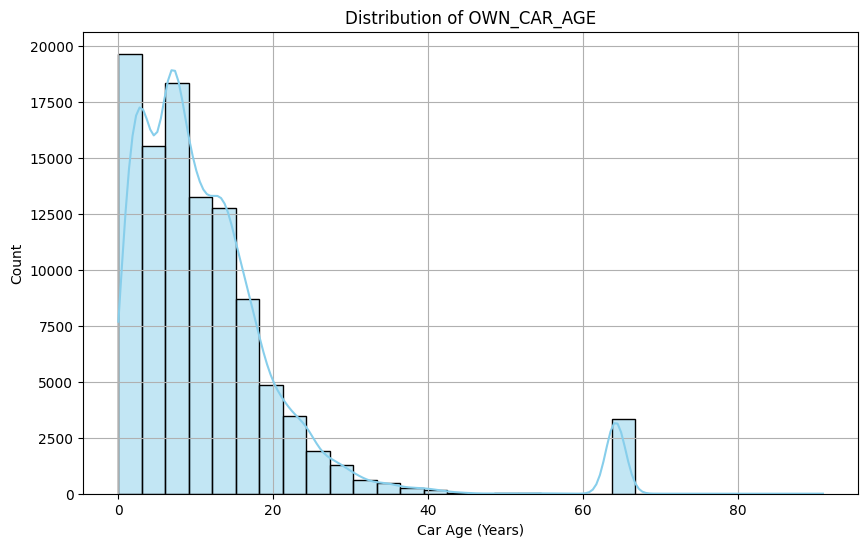

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['OWN_CAR_AGE'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of OWN_CAR_AGE')
plt.xlabel('Car Age (Years)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [27]:
df_train['OWN_CAR_AGE'].value_counts().reset_index().sort_values(by='OWN_CAR_AGE' , ascending=False)

,OWN_CAR_AGE,count
54,91.0,2
58,69.0,1
26,65.0,891
17,64.0,2443
53,63.0,2
...,...,...
5,4.0,5557
2,3.0,6370
4,2.0,5852
6,1.0,5280


 dropped the OWN_CAR_AGE column and replaced it with a binary column called HAS_CAR.

The reason is:

Over 66% of applicants had no car age recorded, meaning most likely don't own a car.

This makes sense because many people who apply for loans can’t afford a car or don’t need one — especially in lower-income brackets.

Keeping the detailed car age would create unreliable imputations, while a simple yes/no flag gives clearer, cleaner insight.

By creating a HAS_CAR feature:

We capture whether car ownership exists at all, which is still useful for modeling.

We reduce noise and improve model robustness by avoiding high-missing-value columns.

In [28]:
df_train['HAS_CAR'] = df_train['OWN_CAR_AGE'].notna().astype(int)
df_test['HAS_CAR'] = df_test['OWN_CAR_AGE'].notna().astype(int)

df_train.drop(columns=['OWN_CAR_AGE'], inplace=True)
df_test.drop(columns=['OWN_CAR_AGE'], inplace=True)



next lets make sure emoty values inEXT_SOURCE_1 are replaced with nan and tree models will handle them

In [29]:
# Ensure EXT_SOURCE_1 missing values are NaN (if not already)
df_train['EXT_SOURCE_1'] = df_train['EXT_SOURCE_1'].where(pd.notnull(df_train['EXT_SOURCE_1']), np.nan)
df_test['EXT_SOURCE_1'] = df_test['EXT_SOURCE_1'].where(pd.notnull(df_test['EXT_SOURCE_1']), np.nan)


now we have EXT_SOURCE_3 in which i will investigate now and some columns with less than 1% null which i can just remove them.

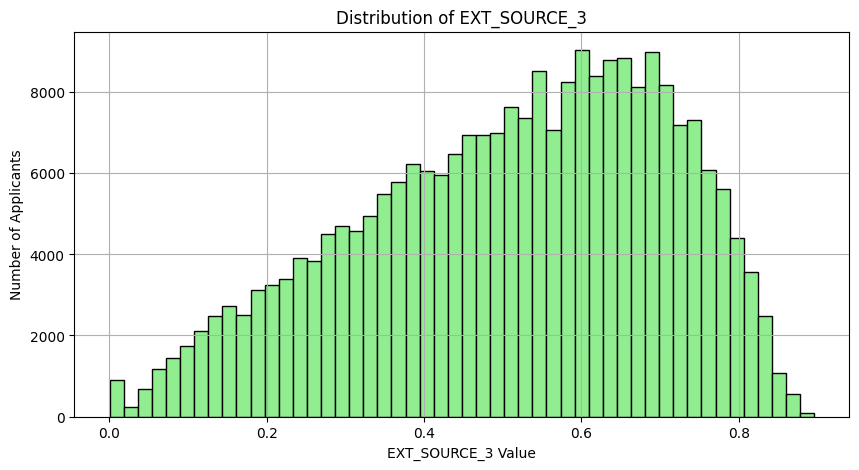

In [30]:

# Plot histogram for EXT_SOURCE_3 (including missing values dropped)
plt.figure(figsize=(10, 5))
df_train['EXT_SOURCE_3'].dropna().hist(bins=50, color='lightgreen', edgecolor='black')

plt.title('Distribution of EXT_SOURCE_3')
plt.xlabel('EXT_SOURCE_3 Value')
plt.ylabel('Number of Applicants')
plt.grid(True)
plt.show()


In [31]:
df_train['EXT_SOURCE_3'].describe()

,EXT_SOURCE_3
count,246546.000000
mean,0.510853
std,0.194844
min,0.000527
25%,0.370650
50%,0.535276
75%,0.669057
max,0.896010


I chose to fill the missing values in EXT_SOURCE_3 with the median because this column represents a score (between 0 and 1) from an external source that helps measure how risky a person might be

If i use 0, it would look like the person is extremely risky, which may not be true , they might just be missing data

If i use the mean, it could be pulled up or down by unusual values (outliers).

The median is safer because it's the middle value, not affected by outliers, and it keeps things fair and neutral

So, using the median helps  avoid giving wrong signals to the model and keeps the data more realistic

In [32]:
median_score3 = df_train['EXT_SOURCE_3'].median()
df_train['EXT_SOURCE_3'].fillna(median_score3, inplace=True)
df_test['EXT_SOURCE_3'].fillna(median_score3, inplace=True)


/tmp/ipython-input-32-1701392442.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['EXT_SOURCE_3'].fillna(median_score3, inplace=True)
/tmp/ipython-input-32-1701392442.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

i chose to drop rows with missing values in these columns because:

The percentage of missing data is low to moderate.

Dropping them won't significantly reduce the dataset size.

It helps  avoid incorrect imputation that could affect model accuracy.

Especially for things like family count or phone change days, guessing could be misleading.

This way i keep only clean, complete records for modeling.

In [33]:
cols_to_clean = [
    'NAME_TYPE_SUITE',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY',
    'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'
]

df_train.dropna(subset=cols_to_clean, inplace=True)
df_test.dropna(subset=cols_to_clean, inplace=True)


In [34]:
print(df_train.shape)
print(df_test.shape)

(304531, 74)
(47772, 73)


check if there are duplicates row or ID

In [35]:
df_train.duplicated().sum()

np.int64(0)

In [36]:
pd.set_option('display.max_columns', None)

df_train.describe()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,HAS_CAR
count,304531.000000,304531.000000,304531.000000,3.045310e+05,3.045310e+05,304531.000000,3.045310e+05,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.0,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,132879.000000,3.045310e+05,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000,304531.000000
mean,278171.558800,0.081000,0.417140,1.686634e+05,5.995592e+05,27146.369655,5.384949e+05,0.020842,-16040.509915,63831.232423,-4986.687785,-2994.732070,1.0,0.819841,0.199730,0.998141,0.281278,0.056881,2.153163,2.053328,2.032302,12.060079,0.015154,0.050675,0.040518,0.078212,0.230630,0.179709,0.501986,5.142203e-01,0.515614,1.422052,0.143421,1.405131,0.100069,-965.330085,0.000043,0.712860,0.000082,0.014708,0.088067,0.000138,0.081670,0.003852,0.000020,0.003845,0.000007,0.003425,0.002821,0.001133,0.009447,0.000263,0.007851,0.000575,0.000496,0.000328,0.005523,0.006039,0.029829,0.231635,0.230203,1.648630,0.340258
std,102782.532925,0.272836,0.722308,2.378910e+05,4.021453e+05,14480.104699,3.690524e+05,0.013808,4361.978717,141291.148422,3521.601095,1509.373915,0.0,0.384320,0.399798,0.043071,0.449624,0.231615,0.910638,0.508890,0.502616,3.265884,0.122167,0.219333,0.197171,0.268505,0.421237,0.383946,0.211049,1.911246e-01,0.174780,2.401424,0.446721,2.380308,0.362388,826.943447,0.006534,0.452428,0.009060,0.120381,0.283392,0.011743,0.273862,0.061944,0.004439,0.061891,0.002563,0.058423,0.053036,0.033639,0.096737,0.016206,0.088260,0.023965,0.022262,0.018118,0.077957,0.102667,0.190669,0.856216,0.745648,1.856842,0.473796
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014568,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189138.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16573.500000,2.385000e+05,0.010006,-19682.000000,-2762.000000,-7478.0

- the ID columns will be removed not needed for modelling
- cnt_childer could be investigated
- days_birth needs investigation
- days_employed needs investigation
- dayes_registeration , id publish as well needs investigation
- also mobile flags columns needs extra investigations
-   'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE' these as well need extra considerations


In [37]:

print(df_train['DAYS_EMPLOYED'].value_counts().sort_index())

DAYS_EMPLOYED
-17912         1
-17583         1
-17546         1
-17531         1
-17522         1
           ...  
-3             3
-2             2
-1             1
 0             2
 365243    54852
Name: count, Length: 12556, dtype: int64


looks like the number 365243 indicates that this value is missing and it is not by luck.

In [38]:
## Create a binary feature to capture this placeholder
df_train['DAYS_EMPLOYED_FLAG'] = (df_train['DAYS_EMPLOYED'] == 365243).astype(int)
df_test['DAYS_EMPLOYED_FLAG'] = (df_test['DAYS_EMPLOYED'] == 365243).astype(int)
# Replace placeholder value with NaN so it doesn’t affect modell
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243, np.nan)
df_test['DAYS_EMPLOYED'] = df_test['DAYS_EMPLOYED'].replace(365243, np.nan)


In this case, it is smart to replace the positive value 365243 with NaN because we intend to use a tree-based model, which can natively handle missing values. Unlike other columns where missing data may be ambiguous or due to random omission, the value 365243 is not random — it is a deliberate placeholder that likely indicates the applicant is unemployed or not currently working.

By converting it to NaN, we preserve the true semantic meaning of the data and allow the model to treat it as a distinct and informative missing signal, rather than misleading it with an artificially large number. This strategy improves the model's ability to learn correct patterns from the data.

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304531 entries, 0 to 307510
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   304531 non-null  int64  
 1   TARGET                       304531 non-null  int64  
 2   NAME_CONTRACT_TYPE           304531 non-null  object 
 3   CODE_GENDER                  304531 non-null  object 
 4   FLAG_OWN_CAR                 304531 non-null  object 
 5   FLAG_OWN_REALTY              304531 non-null  object 
 6   CNT_CHILDREN                 304531 non-null  int64  
 7   AMT_INCOME_TOTAL             304531 non-null  float64
 8   AMT_CREDIT                   304531 non-null  float64
 9   AMT_ANNUITY                  304531 non-null  float64
 10  AMT_GOODS_PRICE              304531 non-null  float64
 11  NAME_TYPE_SUITE              304531 non-null  object 
 12  NAME_INCOME_TYPE             304531 non-null  object 
 13  NAME

lets now see cnt_children

In [40]:
df_train['CNT_CHILDREN'].value_counts().sort_index()


,count
CNT_CHILDREN,
0,213277
1,60520
2,26502
3,3680
4,426
5,84
6,21
7,7
8,2


best approach is to group them

In [41]:
def categorize_children(x):
    if x <= 2:
        return 'Low'
    elif x <= 5:
        return 'Medium'
    elif x <= 7:
        return 'High'
    else:
        return 'Very_High'

# Apply categorization
df_train['CNT_CHILDREN_GROUP'] = df_train['CNT_CHILDREN'].apply(categorize_children)
df_test['CNT_CHILDREN_GROUP'] = df_test['CNT_CHILDREN'].apply(categorize_children)

# Drop the original column
df_train.drop(columns=['CNT_CHILDREN'], inplace=True)
df_test.drop(columns=['CNT_CHILDREN'], inplace=True)




lets investigate the DAYS_BIRTH columns

In [42]:
df_train['AGE_YEARS'] = (-df_train['DAYS_BIRTH'] / 365).round(1)
df_train.drop('DAYS_BIRTH', axis=1, inplace=True)

df_test['AGE_YEARS'] = (-df_test['DAYS_BIRTH'] / 365).round(1)
df_test.drop('DAYS_BIRTH', axis=1, inplace=True)



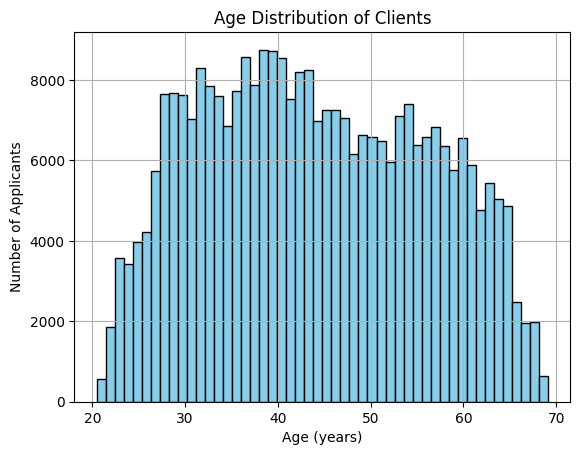

In [43]:
plt.hist(df_train['AGE_YEARS'], bins=50, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Clients')
plt.xlabel('Age (years)')
plt.ylabel('Number of Applicants')
plt.grid(True)
plt.show()


distribution looks fine and nothing extra to change

Since DAYS_BIRTH is negative (e.g., -12000), it means the person was born 12,000 days before application.

That means:

All other date values (like ID publish, registration) should be:

Greater than or equal to DAYS_BIRTH (i.e., closer to today)

And less than or equal to 0 (since all are "days before application")

In [44]:
# For training set
df_train = df_train[
    (df_train['DAYS_ID_PUBLISH'] >= -df_train['AGE_YEARS'] * 365) &
    (df_train['DAYS_REGISTRATION'] >= -df_train['AGE_YEARS'] * 365)
]

# For test set
df_test = df_test[
    (df_test['DAYS_ID_PUBLISH'] >= -df_test['AGE_YEARS'] * 365) &
    (df_test['DAYS_REGISTRATION'] >= -df_test['AGE_YEARS'] * 365)
]



In [45]:
contact_cols = [
    'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'
]

# Show unique value counts and percentages
for col in contact_cols:
    print(f"\n--- {col} ---")
    print(df_train[col].value_counts(dropna=False))
    print((df_train[col].value_counts(normalize=True, dropna=False) * 100).round(2).astype(str) + '%')

# Check logical mismatch: No mobile phone, but other contacts present
mask = (df_train['FLAG_MOBIL'] == 0) & (
    (df_train['FLAG_EMP_PHONE'] == 1) |
    (df_train['FLAG_WORK_PHONE'] == 1) |
    (df_train['FLAG_PHONE'] == 1) |
    (df_train['FLAG_CONT_MOBILE'] == 1) |
    (df_train['FLAG_EMAIL'] == 1)
)

print(f" Number of applicants with FLAG_MOBIL = 0 but other contact info = 1: {mask.sum()}")



--- FLAG_MOBIL ---
FLAG_MOBIL
1    303897
Name: count, dtype: int64
FLAG_MOBIL
1    100.0%
Name: proportion, dtype: object

--- FLAG_CONT_MOBILE ---
FLAG_CONT_MOBILE
1    303332
0       565
Name: count, dtype: int64
FLAG_CONT_MOBILE
1    99.81%
0     0.19%
Name: proportion, dtype: object

--- FLAG_EMP_PHONE ---
FLAG_EMP_PHONE
1    249042
0     54855
Name: count, dtype: int64
FLAG_EMP_PHONE
1    81.95%
0    18.05%
Name: proportion, dtype: object

--- FLAG_WORK_PHONE ---
FLAG_WORK_PHONE
0    243233
1     60664
Name: count, dtype: int64
FLAG_WORK_PHONE
0    80.04%
1    19.96%
Name: proportion, dtype: object

--- FLAG_PHONE ---
FLAG_PHONE
0    218405
1     85492
Name: count, dtype: int64
FLAG_PHONE
0    71.87%
1    28.13%
Name: proportion, dtype: object

--- FLAG_EMAIL ---
FLAG_EMAIL
0    286638
1     17259
Name: count, dtype: int64
FLAG_EMAIL
0    94.32%
1     5.68%
Name: proportion, dtype: object
 Number of applicants with FLAG_MOBIL = 0 but other contact info = 1: 0


FLAG_MOBIL is not useful for modeling because it has no variance (100% are 1). So you can safely drop it.

In [46]:
df_train.drop(columns=['FLAG_MOBIL'], inplace=True)
df_test.drop(columns=['FLAG_MOBIL'], inplace=True)


last thing to examine is ---> OBS_30_CNT_SOCIAL_CIRCLE	DEF_30_CNT_SOCIAL_CIRCLE	OBS_60_CNT_SOCIAL_CIRCLE	DEF_60_CNT_SOCIAL_CIRCLE


--- OBS_30_CNT_SOCIAL_CIRCLE ---
OBS_30_CNT_SOCIAL_CIRCLE
0.0      162540
1.0       48378
2.0       29557
3.0       20136
4.0       14008
5.0        9482
6.0        6405
7.0        4350
8.0        2930
9.0        1988
10.0       1364
11.0        845
12.0        644
13.0        406
14.0        258
15.0        164
16.0        133
17.0         87
18.0         46
19.0         44
20.0         30
21.0         29
22.0         22
23.0         15
24.0         11
25.0         11
26.0          3
27.0          5
28.0          1
29.0          1
30.0          2
47.0          1
348.0         1
Name: count, dtype: int64

% Distribution:
OBS_30_CNT_SOCIAL_CIRCLE
0.0      53.485227
1.0      15.919209
2.0       9.725993
3.0       6.625929
4.0       4.609456
5.0       3.120136
6.0       2.107622
7.0       1.431406
8.0       0.964142
9.0       0.654169
10.0      0.448836
11.0      0.278055
12.0      0.211914
13.0      0.133598
14.0      0.084897
15.0      0.053966
16.0      0.043765
17.0      0.028628
18.

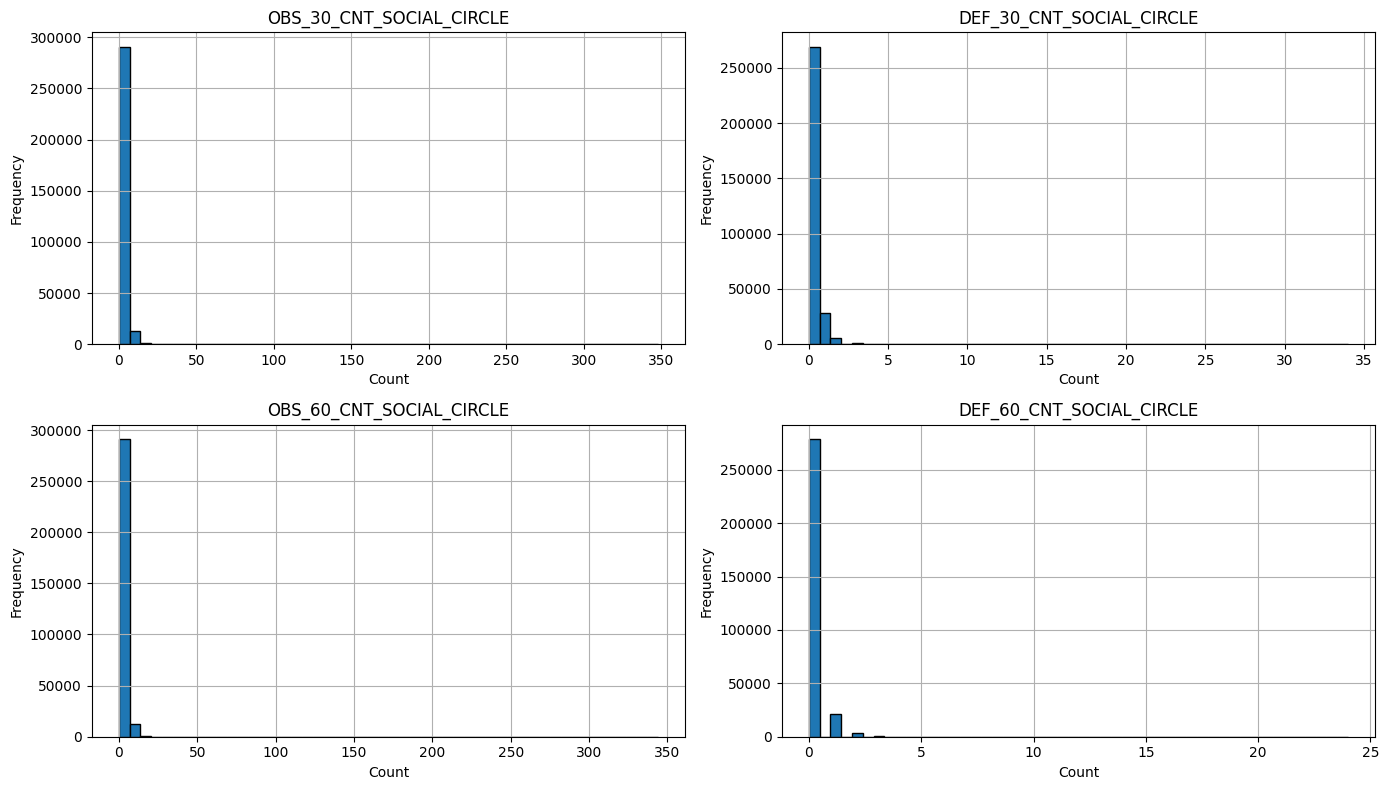

In [47]:
cols = [
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE'
]


for col in cols:
    print(f"\n--- {col} ---")
    print(df_train[col].value_counts().sort_index())
    print("\n% Distribution:")
    print(df_train[col].value_counts(normalize=True).sort_index() * 100)

plt.figure(figsize=(14, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    df_train[col].hist(bins=50, edgecolor='black')
    plt.title(col)
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [48]:
def bin_social_circle(value):
    if pd.isna(value):
        return np.nan
    elif value <= 5:
        return '0–5'
    elif value <= 10:
        return '6–10'
    else:
        return '11+'

columns_to_bin = [
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE'
]

# Apply binning and drop original columns
for col in columns_to_bin:
    bin_col_name = col + '_BIN'
    df_train[bin_col_name] = df_train[col].apply(bin_social_circle)
    df_test[bin_col_name] = df_test[col].apply(bin_social_circle)

    # Drop original columns
    df_train.drop(columns=[col], inplace=True)
    df_test.drop(columns=[col], inplace=True)



In [49]:
print(df_train.shape)
print(df_test.shape)

(303897, 74)
(47693, 73)


In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303897 entries, 0 to 307510
Data columns (total 74 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    303897 non-null  int64  
 1   TARGET                        303897 non-null  int64  
 2   NAME_CONTRACT_TYPE            303897 non-null  object 
 3   CODE_GENDER                   303897 non-null  object 
 4   FLAG_OWN_CAR                  303897 non-null  object 
 5   FLAG_OWN_REALTY               303897 non-null  object 
 6   AMT_INCOME_TOTAL              303897 non-null  float64
 7   AMT_CREDIT                    303897 non-null  float64
 8   AMT_ANNUITY                   303897 non-null  float64
 9   AMT_GOODS_PRICE               303897 non-null  float64
 10  NAME_TYPE_SUITE               303897 non-null  object 
 11  NAME_INCOME_TYPE              303897 non-null  object 
 12  NAME_EDUCATION_TYPE           303897 non-null  ob

After evaluating my model on the validation set, I observed that certain feature, particularly EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3 had the highest impact on performance based on the feature importance analysis. Based on these findings, I decided to revisit and enhance my feature engineering process.

Specifically, I introduced interaction terms between these three key features to capture potential non-linear relationships. Additionally, I added other engineered features, such as financial ratios, which were inspired by patterns observed during validation analysis. This iterative approach—training, validating, analyzing, and refining helped improve the model’s ability to generalize.
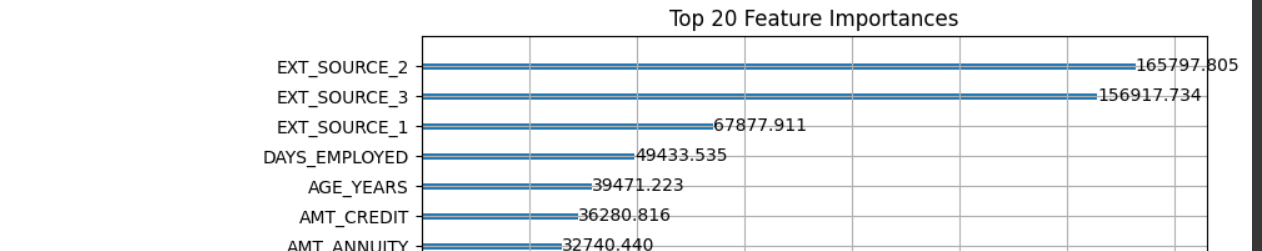

In [51]:
# 1. EXT_SOURCE combinations
df_train['EXT_SOURCE_1_x_2'] = df_train['EXT_SOURCE_1'] * df_train['EXT_SOURCE_2']
df_train['EXT_SOURCE_1_x_3'] = df_train['EXT_SOURCE_1'] * df_train['EXT_SOURCE_3']
df_train['EXT_SOURCE_2_x_3'] = df_train['EXT_SOURCE_2'] * df_train['EXT_SOURCE_3']

df_test['EXT_SOURCE_1_x_2'] = df_test['EXT_SOURCE_1'] * df_test['EXT_SOURCE_2']
df_test['EXT_SOURCE_1_x_3'] = df_test['EXT_SOURCE_1'] * df_test['EXT_SOURCE_3']
df_test['EXT_SOURCE_2_x_3'] = df_test['EXT_SOURCE_2'] * df_test['EXT_SOURCE_3']

# 2. CREDIT to INCOME Ratio
df_train['CREDIT_INCOME_RATIO'] = df_train['AMT_CREDIT'] / df_train['AMT_INCOME_TOTAL']
df_test['CREDIT_INCOME_RATIO'] = df_test['AMT_CREDIT'] / df_test['AMT_INCOME_TOTAL']

# 3. ANNUITY to INCOME Ratio
df_train['ANNUITY_INCOME_RATIO'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']
df_test['ANNUITY_INCOME_RATIO'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']

# 4. GOODS PRICE to CREDIT Ratio
df_train['GOODS_CREDIT_RATIO'] = df_train['AMT_GOODS_PRICE'] / df_train['AMT_CREDIT']
df_test['GOODS_CREDIT_RATIO'] = df_test['AMT_GOODS_PRICE'] / df_test['AMT_CREDIT']




# Encoding -  one hot

In [52]:
df_for_merging = df_train.copy()

In [53]:
df_train.drop(columns=['SK_ID_CURR'], inplace=True)
df_test.drop(columns=['SK_ID_CURR'], inplace=True)

In the next few cells, I will handle encoding, perform resampling, and split the data into separate training, validation, and test sets. I initially assumed the provided test CSV file could be used for evaluation, but upon reviewing the Kaggle documentation, I realized it is intended solely for submission. Therefore, it cannot be used to assess the performance of my model.

In [54]:
#Identify categorical columns (object type)
cat_cols = df_train.select_dtypes(include='object').columns.tolist()
#Encode the training data
df_train_encoded = pd.get_dummies(df_train, columns=cat_cols, drop_first=True)

#Encode the test data
df_test_encoded = pd.get_dummies(df_test, columns=cat_cols, drop_first=True)

#Align test to train columns (fill missing with 0)
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)


In [55]:
X_train = df_train_encoded.drop(columns=['TARGET'])
y_train = df_train_encoded['TARGET']


In [56]:
X_test = df_test_encoded


In [57]:
# Clean column names for both train and test sets
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)


In [58]:
X_train_split, X_holdout, y_train_split, y_holdout = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [59]:

X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train_split, y_train_split,
    test_size=0.2,  # 20% of 80% = 16% total
    stratify=y_train_split,
    random_state=42
)


In [60]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_final, y_train_final)



# LightGBM Grid Search



In [61]:

# 2. Define the LGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# 3. Parameter grid for tuning
lgb_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

# 4. GridSearchCV with f1_weighted scoring
lgb_grid = GridSearchCV(lgb_model, lgb_param_grid, cv=3, scoring='f1_weighted')
lgb_grid.fit(X_train_resampled, y_train_resampled)

# 5. Get the best model from grid search
best_model = lgb_grid.best_estimator_

# 6. Evaluate weighted metrics using CV on resampled data
precision = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=3,
                            scoring=make_scorer(precision_score, average='weighted')).mean()
recall = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=3,
                         scoring=make_scorer(recall_score, average='weighted')).mean()
f1 = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=3,
                     scoring=make_scorer(f1_score, average='weighted')).mean()

# 7. Print results
print("Best LGBM Params:", lgb_grid.best_params_)
print("Best Weighted F1 Score (CV mean):", lgb_grid.best_score_)
print("Weighted Precision (CV mean):", precision)
print("Weighted Recall (CV mean):", recall)
print("Weighted F1-score (CV mean):", f1)


[LightGBM] [Info] Number of positive: 119171, number of negative: 119171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.428232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4963
[LightGBM] [Info] Number of data points in the train set: 238342, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 119172, number of negative: 119171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.474542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4972
[LightGBM] [Info] Number of data points in the train set: 238343, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> inits

# CatBoost Grid Search

In [62]:

# 2. Define the CatBoost model
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# 3. Hyperparameter grid
cat_param_grid = {
    'depth': [4, 6],
    'learning_rate': [0.1, 0.01],
    'iterations': [100, 200]
}

# 4. GridSearchCV on resampled data
cat_grid = GridSearchCV(cat_model, cat_param_grid, cv=3, scoring='f1_weighted')
cat_grid.fit(X_train_resampled, y_train_resampled)

# 5. Get best estimator
best_cat_model = cat_grid.best_estimator_

# 6. Cross-validated metrics on resampled training set
cat_precision = cross_val_score(best_cat_model, X_train_resampled, y_train_resampled, cv=3,
                                scoring=make_scorer(precision_score, average='weighted')).mean()
cat_recall = cross_val_score(best_cat_model, X_train_resampled, y_train_resampled, cv=3,
                             scoring=make_scorer(recall_score, average='weighted')).mean()
cat_f1 = cross_val_score(best_cat_model, X_train_resampled, y_train_resampled, cv=3,
                         scoring=make_scorer(f1_score, average='weighted')).mean()

# 7. Print results
print("Best CatBoost Params:", cat_grid.best_params_)
print("Best Weighted F1 Score (CV mean):", cat_grid.best_score_)
print("Weighted Precision (CV mean):", cat_precision)
print("Weighted Recall (CV mean):", cat_recall)
print("Weighted F1-score (CV mean):", cat_f1)


Best CatBoost Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best Weighted F1 Score (CV mean): 0.7144106271877089
Weighted Precision (CV mean): 0.7144240688310339
Weighted Recall (CV mean): 0.7144139862283705
Weighted F1-score (CV mean): 0.7144106271877089


# Evaluation

in the following cells, I experimented with different classification thresholds and evaluated the recall for both classes. This analysis is important because, from a business perspective, identifying individuals who are likely to default on their loans (class 1) is typically more critical than those who will repay. Adjusting the threshold allows us to balance the trade-off between catching more defaulters and minimizing false positives.

In [63]:

# 1. Predict probabilities for the positive class (class 1)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

# 2. Define thresholds to try
thresholds = np.arange(0.1, 0.91, 0.05)

# 3. Loop through thresholds and print metrics
print(f"{'Threshold':<10} | {'Recall_0':<9} | {'Recall_1':<9} | {'Macro_F1':<9}")
print("-" * 45)

for t in thresholds:
    y_pred_thresh = (y_valid_proba >= t).astype(int)
    recall_0 = recall_score(y_valid, y_pred_thresh, pos_label=0)
    recall_1 = recall_score(y_valid, y_pred_thresh, pos_label=1)
    macro_f1 = f1_score(y_valid, y_pred_thresh, average='macro')
    print(f"{t:<10.2f} | {recall_0:<9.3f} | {recall_1:<9.3f} | {macro_f1:<9.3f}")


Threshold  | Recall_0  | Recall_1  | Macro_F1 
---------------------------------------------
0.10       | 0.110     | 0.981     | 0.180    
0.15       | 0.207     | 0.956     | 0.258    
0.20       | 0.306     | 0.926     | 0.328    
0.25       | 0.399     | 0.888     | 0.385    
0.30       | 0.486     | 0.844     | 0.434    
0.35       | 0.563     | 0.799     | 0.474    
0.40       | 0.634     | 0.748     | 0.509    
0.45       | 0.695     | 0.691     | 0.538    
0.50       | 0.754     | 0.626     | 0.564    
0.55       | 0.805     | 0.560     | 0.585    
0.60       | 0.850     | 0.492     | 0.603    
0.65       | 0.891     | 0.412     | 0.614    
0.70       | 0.927     | 0.323     | 0.616    
0.75       | 0.954     | 0.226     | 0.601    
0.80       | 0.978     | 0.146     | 0.581    
0.85       | 0.993     | 0.066     | 0.536    
0.90       | 0.999     | 0.012     | 0.491    


In [64]:
y_holdout_proba = best_model.predict_proba(X_holdout)[:, 1]
y_holdout_pred = (y_holdout_proba >= 0.4).astype(int)

print(classification_report(y_holdout, y_holdout_pred))
print(confusion_matrix(y_holdout, y_holdout_pred))


              precision    recall  f1-score   support

           0       0.96      0.63      0.76     55862
           1       0.15      0.73      0.25      4918

    accuracy                           0.64     60780
   macro avg       0.56      0.68      0.51     60780
weighted avg       0.90      0.64      0.72     60780

[[35321 20541]
 [ 1332  3586]]


In [65]:
auc = roc_auc_score(y_holdout, y_holdout_proba)
print("ROC AUC on Holdout Set:", round(auc, 4))

ROC AUC on Holdout Set: 0.7474


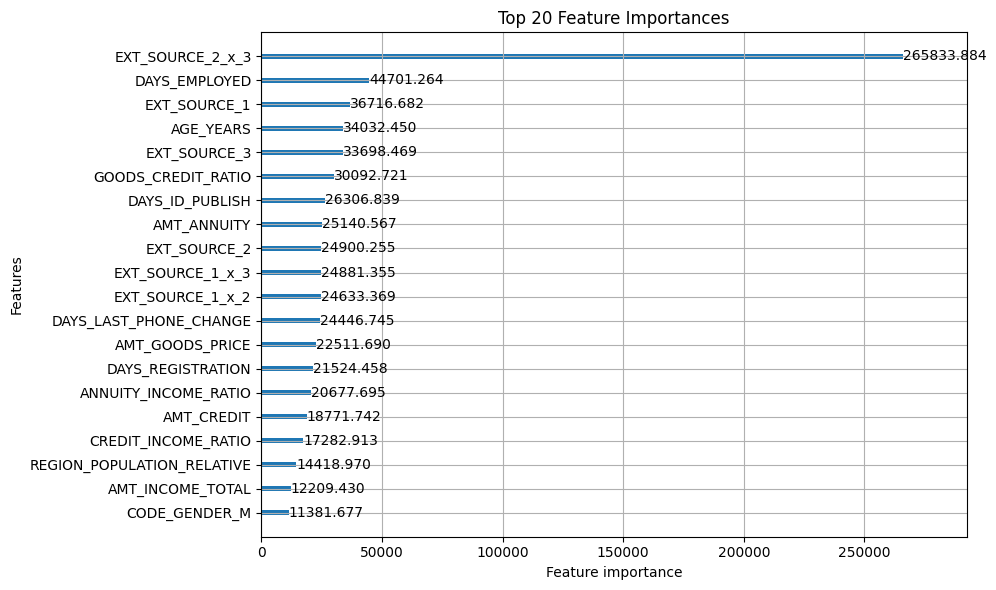

In [66]:

lgb.plot_importance(best_model, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


Our base model has performed fairly well; however, there is still room for improvement. In the following section, I will process the **bureau.csv** file and merge it with our already processed training data. The goal is to retrain the same model using this enriched dataset with additional features to potentially enhance its performance.


# ----------------------------------------------------------

# Bureau csv file processing

# Read file from drive

In [67]:
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/aman task/home-credit-default-risk'
df_bureau = pd.read_csv(f'{folder}/bureau.csv')
print("Train shape:", df_bureau.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape: (1716428, 17)


# EDA

In [68]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [69]:
df_bureau.info()

# Missing value % per column
missing_percentage = df_bureau.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing_percentage)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
Columns with missing values:
 AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVERDUE    65.513264
DAYS_ENDDATE_FACT 

In [70]:
print("CREDIT_ACTIVE:\n", df_bureau['CREDIT_ACTIVE'].value_counts())

print("\nCREDIT_CURRENCY:\n", df_bureau['CREDIT_CURRENCY'].value_counts())

print("\nCREDIT_TYPE:\n", df_bureau['CREDIT_TYPE'].value_counts())


CREDIT_ACTIVE:
 CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64

CREDIT_CURRENCY:
 CREDIT_CURRENCY
currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: count, dtype: int64

CREDIT_TYPE:
 CREDIT_TYPE
Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchas

- Mostly "Closed" and "Active" (99.9%)
- "Sold" and "Bad debt" are very rare → group them as "Other"
- CREDIT_CURRENCY  is 99% currency 1 so no added value i will drop this column


In [71]:
# Drop the 3 unnecessary columns
cols_to_drop = ['AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE', 'CREDIT_CURRENCY','DAYS_CREDIT_ENDDATE']
df_bureau.drop(columns=cols_to_drop, inplace=True)

In [72]:
# Group rare values under 'Other'
df_bureau['CREDIT_ACTIVE_CLEAN'] = df_bureau['CREDIT_ACTIVE'].replace({
    'Sold': 'Other',
    'Bad debt': 'Other'
})
df_bureau.drop(columns=['CREDIT_ACTIVE'], inplace=True)

Now lets investiaget columns that didnt have alot of missing value but had some .

In [73]:
df_bureau['DAYS_ENDDATE_FACT'].describe()


,DAYS_ENDDATE_FACT
count,1.082775e+06
mean,-1.017437e+03
std,7.140106e+02
min,-4.202300e+04
25%,-1.489000e+03
50%,-8.970000e+02
75%,-4.250000e+02
max,0.000000e+00


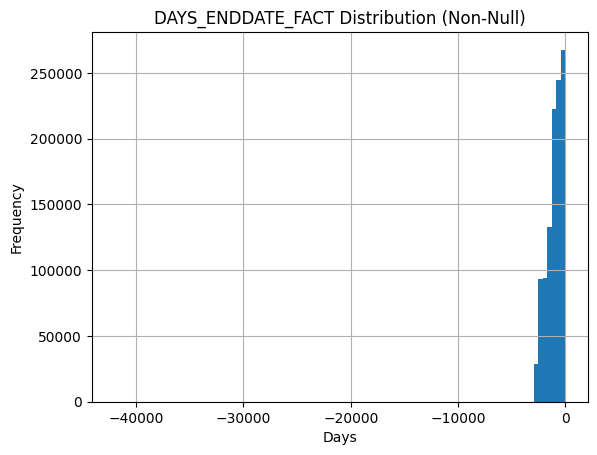

In [74]:
df_bureau['DAYS_ENDDATE_FACT'].dropna().hist(bins=100)
plt.title('DAYS_ENDDATE_FACT Distribution (Non-Null)')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

What Is CREDIT_ACTIVE When This Is Missing?



In [75]:
df_bureau[df_bureau['DAYS_ENDDATE_FACT'].isna()]['CREDIT_ACTIVE_CLEAN'].value_counts()


,count
CREDIT_ACTIVE_CLEAN,
Active,628638
Other,4890
Closed,125


since most nan values corresponds to active credit  , leaving it as NaN and adding a binary flag for active credit is best approach

In [76]:
# Create binary column: 1 if still active (missing end date), else 0
df_bureau['IS_STILL_ACTIVE_FACT'] = df_bureau['DAYS_ENDDATE_FACT'].isna().astype(int)


lets investigate AMT_CREDIT_SUM_LIMIT

What this column means:
Credit limit for revolving loans like credit cards.
It's the maximum amount the client can borrow on those accounts.

Only applicable to credit card loans

Missing values likely mean:
- This is not a credit card
- Or the limit wasn't reported

In [77]:
df_bureau['AMT_CREDIT_SUM_LIMIT'].describe()


,AMT_CREDIT_SUM_LIMIT
count,1.124648e+06
mean,6.229515e+03
std,4.503203e+04
min,-5.864061e+05
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,4.705600e+06


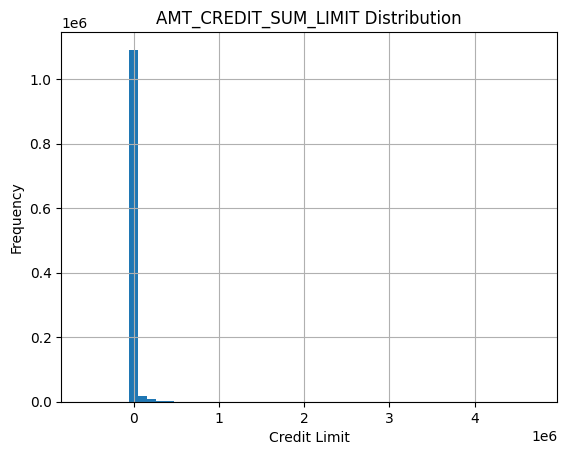

In [78]:
df_bureau['AMT_CREDIT_SUM_LIMIT'].dropna().hist(bins=50)
plt.title('AMT_CREDIT_SUM_LIMIT Distribution')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')
plt.show()



In [79]:
# Credit types where limit is missing
df_bureau[df_bureau['AMT_CREDIT_SUM_LIMIT'].isna()]['CREDIT_TYPE'].value_counts()


,count
CREDIT_TYPE,
Consumer credit,439919
Credit card,117613
Car loan,16527
Microloan,10201
Mortgage,5130
Loan for business development,1803
Loan for working capital replenishment,452
Another type of loan,89
Real estate loan,24


In [80]:

# Credit types where limit is NOT missing
df_bureau[df_bureau['AMT_CREDIT_SUM_LIMIT'].notna()]['CREDIT_TYPE'].value_counts()


,count
CREDIT_TYPE,
Consumer credit,811696
Credit card,284582
Mortgage,13261
Car loan,11163
Microloan,2212
Another type of loan,928
Unknown type of loan,555
Loan for business development,172
Cash loan (non-earmarked),56


Missing Pattern:
Missing for many Credit card and non-credit card types

Present for many non-credit-card loans too (e.g., Consumer credit, Mortgage)

This means: missing values do not exclusively mean “not a credit card”

So we can't fully rely on CREDIT_TYPE == "Credit card" to explain missingness.

hence final suggested is ------> Either the loan type doesn't have a limit or the limit wasn't reported. In either case, it likely means:
“No known available limit for this loan”





In [81]:
# Create binary column to indicate missing credit limit
df_bureau['IS_LIMIT_KNOWN'] = df_bureau['AMT_CREDIT_SUM_LIMIT'].notna().astype(int)


Next we ar moving to AMT_CREDIT_SUM_DEBT
initial insights-->
Missing values may mean:

The credit is fully paid off

Or, no debt was reported

In [82]:
df_bureau['AMT_CREDIT_SUM_DEBT'].describe()


,AMT_CREDIT_SUM_DEBT
count,1.458759e+06
mean,1.370851e+05
std,6.774011e+05
min,-4.705600e+06
25%,0.000000e+00
50%,0.000000e+00
75%,4.015350e+04
max,1.701000e+08


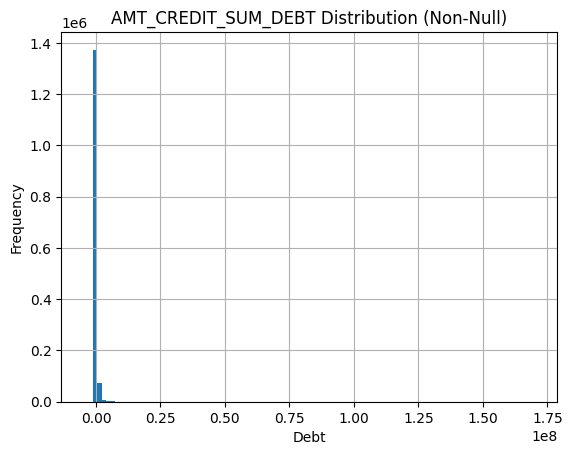

In [83]:
df_bureau['AMT_CREDIT_SUM_DEBT'].dropna().hist(bins=100)
plt.title('AMT_CREDIT_SUM_DEBT Distribution (Non-Null)')
plt.xlabel('Debt')
plt.ylabel('Frequency')
plt.show()


In [84]:
# Credit types where debt is missing
df_bureau[df_bureau['AMT_CREDIT_SUM_DEBT'].isna()]['CREDIT_TYPE'].value_counts()

,count
CREDIT_TYPE,
Consumer credit,200073
Credit card,46105
Car loan,5930
Mortgage,3297
Microloan,1728
Loan for business development,369
Loan for working capital replenishment,117
Another type of loan,32
Real estate loan,12


In [85]:
df_bureau[df_bureau['AMT_CREDIT_SUM_DEBT'].notna()]['CREDIT_TYPE'].value_counts()

,count
CREDIT_TYPE,
Consumer credit,1051542
Credit card,356090
Car loan,21760
Mortgage,15094
Microloan,10685
Loan for business development,1606
Another type of loan,985
Unknown type of loan,555
Loan for working capital replenishment,352


In [86]:
# Create binary flag — was debt reported?
df_bureau['IS_DEBT_REPORTED'] = df_bureau['AMT_CREDIT_SUM_DEBT'].notna().astype(int)

#Fill missing debt values with 0 (safe default for "not reported")
df_bureau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)

# Replace negative debt values with 0 (invalid cases)
df_bureau.loc[df_bureau['AMT_CREDIT_SUM_DEBT'] < 0, 'AMT_CREDIT_SUM_DEBT'] = 0


/tmp/ipython-input-86-3145143308.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_bureau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)


last column to handle is  AMT_CREDIT_SUM  with just 13 rows missing , just impute with median.

In [87]:
median_credit_sum = df_bureau['AMT_CREDIT_SUM'].median()
df_bureau['AMT_CREDIT_SUM'].fillna(median_credit_sum, inplace=True)


/tmp/ipython-input-87-3796021819.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_bureau['AMT_CREDIT_SUM'].fillna(median_credit_sum, inplace=True)


# AGG

Group by SK_ID_CURR and aggregate key numeric columns


In [88]:
num_cols = [
    'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT',
    'AMT_CREDIT_SUM_LIMIT',
    'AMT_CREDIT_SUM_OVERDUE',
    'CNT_CREDIT_PROLONG',
    'CREDIT_DAY_OVERDUE',
    'DAYS_CREDIT',
    'DAYS_CREDIT_UPDATE',
    'DAYS_ENDDATE_FACT',
    'IS_STILL_ACTIVE_FACT',
    'IS_DEBT_REPORTED',
    'IS_LIMIT_KNOWN'
]

# Aggregate using mean, sum, and max
bureau_agg = df_bureau.groupby('SK_ID_CURR')[num_cols].agg(['mean', 'sum', 'max'])

bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
bureau_agg.reset_index(inplace=True)


Categorical Count Aggregations

 Count of CREDIT_ACTIVE_CLEAN (Active, Closed, Other)


In [89]:
# Count how many times each credit status appears per client
active_status = df_bureau.groupby(['SK_ID_CURR', 'CREDIT_ACTIVE_CLEAN']).size().unstack(fill_value=0)

# Rename columns
active_status.columns = [f'BUREAU_STATUS_{col.upper()}' for col in active_status.columns]
active_status.reset_index(inplace=True)


 Count of CREDIT_TYPE_CLEAN (e.g., Credit card, Mortgage, etc.)


In [90]:
# Count number of each credit type per client
credit_type = df_bureau.groupby(['SK_ID_CURR', 'CREDIT_TYPE']).size().unstack(fill_value=0)

# Rename columns for consistency
credit_type.columns = [f'BUREAU_CREDIT_TYPE_{col.replace(" ", "_").replace("-", "_").upper()}' for col in credit_type.columns]

# Reset index to merge later
credit_type.reset_index(inplace=True)


 Combine All Aggregated Features



In [91]:
# Merge all aggregation results into one dataframe
bureau_final = bureau_agg.merge(active_status, on='SK_ID_CURR', how='left')
bureau_final = bureau_final.merge(credit_type, on='SK_ID_CURR', how='left')


# -----------------------------------------------------

# merging Both dataset

In [92]:
df_final = df_for_merging.merge(bureau_final, how='left', on='SK_ID_CURR')


In [93]:
df_final.drop(columns=['SK_ID_CURR'], inplace=True)


# Encoding - one hot

In [94]:
#Identify categorical columns (object type)
cat_cols = df_final.select_dtypes(include='object').columns.tolist()
#Encode the training data
df_train_encoded = pd.get_dummies(df_final, columns=cat_cols, drop_first=True)


In [95]:
X_train = df_train_encoded.drop(columns=['TARGET'])
y_train = df_train_encoded['TARGET']

In [96]:
# Clean column name
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

In [97]:

X_train_split, X_holdout, y_train_split, y_holdout = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)


In [98]:
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train_split, y_train_split,
    test_size=0.2,  # 20% of 80% = 16% total
    stratify=y_train_split,
    random_state=42
)


In [99]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_final, y_train_final)

# LGBM

In [100]:

# 2. Define the LGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# 3. Parameter grid for tuning
lgb_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

# 4. GridSearchCV with f1_weighted scoring
lgb_grid = GridSearchCV(lgb_model, lgb_param_grid, cv=3, scoring='f1_weighted')
lgb_grid.fit(X_train_resampled, y_train_resampled)

# 5. Get the best model from grid search
best_model = lgb_grid.best_estimator_

# 6. Evaluate weighted metrics using CV on resampled data
precision = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=3,
                            scoring=make_scorer(precision_score, average='weighted')).mean()
recall = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=3,
                         scoring=make_scorer(recall_score, average='weighted')).mean()
f1 = cross_val_score(best_model, X_train_resampled, y_train_resampled, cv=3,
                     scoring=make_scorer(f1_score, average='weighted')).mean()

# 7. Print results
print("Best LGBM Params:", lgb_grid.best_params_)
print("Best Weighted F1 Score (CV mean):", lgb_grid.best_score_)
print("Weighted Precision (CV mean):", precision)
print("Weighted Recall (CV mean):", recall)
print("Weighted F1-score (CV mean):", f1)


[LightGBM] [Info] Number of positive: 119171, number of negative: 119171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.258499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11919
[LightGBM] [Info] Number of data points in the train set: 238342, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 119172, number of negative: 119171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.259087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11925
[LightGBM] [Info] Number of data points in the train set: 238343, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> ini

# CatBoost

In [101]:

# 2. Define the CatBoost model
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# 3. Hyperparameter grid
cat_param_grid = {
    'depth': [4, 6],
    'learning_rate': [0.1, 0.01],
    'iterations': [100, 200]
}

# 4. GridSearchCV on resampled data
cat_grid = GridSearchCV(cat_model, cat_param_grid, cv=3, scoring='f1_weighted')
cat_grid.fit(X_train_resampled, y_train_resampled)

# 5. Get best estimator
best_cat_model = cat_grid.best_estimator_

# 6. Cross-validated metrics on resampled training set
cat_precision = cross_val_score(best_cat_model, X_train_resampled, y_train_resampled, cv=3,
                                scoring=make_scorer(precision_score, average='weighted')).mean()
cat_recall = cross_val_score(best_cat_model, X_train_resampled, y_train_resampled, cv=3,
                             scoring=make_scorer(recall_score, average='weighted')).mean()
cat_f1 = cross_val_score(best_cat_model, X_train_resampled, y_train_resampled, cv=3,
                         scoring=make_scorer(f1_score, average='weighted')).mean()

# 7. Print results
print("Best CatBoost Params:", cat_grid.best_params_)
print("Best Weighted F1 Score (CV mean):", cat_grid.best_score_)
print("Weighted Precision (CV mean):", cat_precision)
print("Weighted Recall (CV mean):", cat_recall)
print("Weighted F1-score (CV mean):", cat_f1)


Best CatBoost Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best Weighted F1 Score (CV mean): 0.7220533485037143
Weighted Precision (CV mean): 0.722074698990883
Weighted Recall (CV mean): 0.7220584437059747
Weighted F1-score (CV mean): 0.7220533485037143


# Evaluation

In [102]:

# 1. Predict probabilities for the positive class (class 1)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

# 2. Define thresholds to try
thresholds = np.arange(0.1, 0.91, 0.05)

# 3. Loop through thresholds and print metrics
print(f"{'Threshold':<10} | {'Recall_0':<9} | {'Recall_1':<9} | {'Macro_F1':<9}")
print("-" * 45)

for t in thresholds:
    y_pred_thresh = (y_valid_proba >= t).astype(int)
    recall_0 = recall_score(y_valid, y_pred_thresh, pos_label=0)
    recall_1 = recall_score(y_valid, y_pred_thresh, pos_label=1)
    macro_f1 = f1_score(y_valid, y_pred_thresh, average='macro')
    print(f"{t:<10.2f} | {recall_0:<9.3f} | {recall_1:<9.3f} | {macro_f1:<9.3f}")


Threshold  | Recall_0  | Recall_1  | Macro_F1 
---------------------------------------------
0.10       | 0.121     | 0.978     | 0.190    
0.15       | 0.226     | 0.954     | 0.272    
0.20       | 0.329     | 0.919     | 0.342    
0.25       | 0.423     | 0.879     | 0.399    
0.30       | 0.507     | 0.829     | 0.445    
0.35       | 0.584     | 0.786     | 0.485    
0.40       | 0.650     | 0.737     | 0.518    
0.45       | 0.710     | 0.684     | 0.546    
0.50       | 0.764     | 0.612     | 0.568    
0.55       | 0.814     | 0.548     | 0.589    
0.60       | 0.857     | 0.477     | 0.604    
0.65       | 0.895     | 0.400     | 0.614    
0.70       | 0.930     | 0.324     | 0.620    
0.75       | 0.958     | 0.237     | 0.611    
0.80       | 0.979     | 0.147     | 0.583    
0.85       | 0.994     | 0.064     | 0.535    
0.90       | 0.999     | 0.011     | 0.490    


In [103]:
y_holdout_proba = best_model.predict_proba(X_holdout)[:, 1]
y_holdout_pred = (y_holdout_proba >= 0.4).astype(int)

print(classification_report(y_holdout, y_holdout_pred))
print(confusion_matrix(y_holdout, y_holdout_pred))


              precision    recall  f1-score   support

           0       0.96      0.65      0.78     55862
           1       0.15      0.72      0.25      4918

    accuracy                           0.66     60780
   macro avg       0.56      0.68      0.51     60780
weighted avg       0.90      0.66      0.73     60780

[[36326 19536]
 [ 1382  3536]]


In [104]:
auc = roc_auc_score(y_holdout, y_holdout_proba)
print("ROC AUC on Holdout Set:", round(auc, 4))

ROC AUC on Holdout Set: 0.7512


Good sign that our new fetaures did some differnce , however there is still big room of improvement by adding ALL the other csv file and we can reach auc of 0.8+

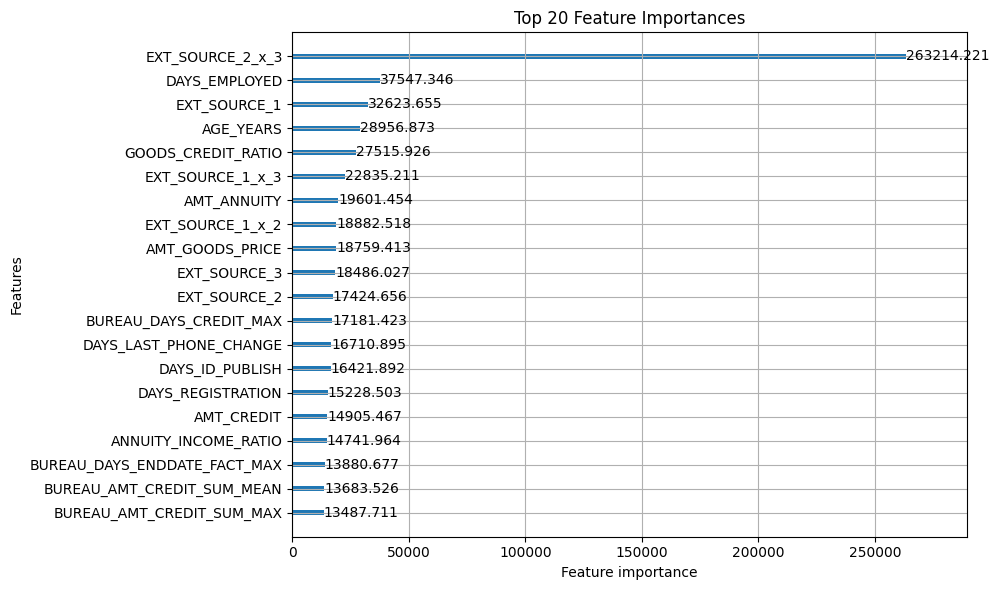

In [105]:

lgb.plot_importance(best_model, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()
